In [3]:
import csv
import pandas as pd
import numpy as np
import gzip
from patsy import dmatrix
import shutil
import matplotlib.colors as mcolors
from sklearn.feature_selection import f_classif
import dataframe_image as dfi
import dask.dataframe as dd
from matplotlib.colors import TwoSlopeNorm
from sklearn.linear_model import LogisticRegression
import pyarrow.csv as pv
from matplotlib.colors import LogNorm
from sklearn import tree
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
import pyarrow.parquet as pq
from sklearn.tree import export_graphviz
import graphviz
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lifelines.utils import k_fold_cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.tree import plot_tree
from sklearn.datasets import make_regression
import seaborn as sns
import dask.dataframe as dd
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from numpy.polynomial.polynomial import Polynomial
import sys
import shap
from lifelines import CoxPHFitter
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import lifelines
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.interpolate import UnivariateSpline
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sksurv.tree import SurvivalTree
from sksurv.util import Surv
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sklearn.metrics import log_loss
from scipy.stats import entropy
import pickle
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test
from statsmodels.nonparametric.smoothers_lowess import lowess
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn_pandas import DataFrameMapper
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import brier_score
from sklearn.preprocessing import OrdinalEncoder
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from matplotlib.ticker import FuncFormatter
from lifelines.statistics import logrank_test

In [4]:
df_alch = pd.read_csv('thesis__data.csv', usecols = ['ALCDAYSYR', 'ALCSTAT1', 'ALCLIFE', 'MORTSTAT'])

In [5]:
# use only samples availabel for mortality status tracking
df_alch = df_alch[(df_alch['MORTSTAT'] == 1) | (df_alch['MORTSTAT'] == 2)]

# fix universe
df_alch = df_alch[(df_alch['ALCSTAT1']==1) | (df_alch['ALCSTAT1']==2) | (df_alch['ALCSTAT1']==3) |(df_alch['ALCLIFE']==1) | (df_alch['ALCLIFE']==2)]
df_alch = df_alch[(df_alch['ALCDAYSYR'] <= 365)]

In [6]:
# count occurrences of each value of ALCDAYSYR
value_counts = df_alch['ALCDAYSYR'].value_counts().sort_index()

In [7]:
# find quantiles of ALCDAYSYR
df_alch["ALCDAYSYR"].quantile([0.2, 0.4, 0.6, 0.8])

0.2      0.0
0.4     10.0
0.6     36.0
0.8    104.0
Name: ALCDAYSYR, dtype: float64

In [8]:
# bin values based on equal-frequency binning approach
df_alch_q = df_alch.copy()

df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 0 if x == 0  else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 1 if 1 <= x <= 10 else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 2 if 11 <= x <= 36 else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 3 if 37 <= x <= 104 else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 4 if 105 <= x else x)

# count number of samples in each bin
value_counts_q = df_alch_q['ALCDAYSYR'].value_counts().sort_index()

In [9]:
# bin values based on rationale-based binning approach
df_alch_kn = df_alch.copy()

df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 0 if x <=3  else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 1 if 4 <= x <= 10 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 2 if 11 <= x <= 26 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 3 if 26 <= x <= 52 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 4 if 53 <= x <=104 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 5 if 105 <= x else x)

# count occurrences of each value
value_counts_kn = df_alch_kn['ALCDAYSYR'].value_counts().sort_index()

In [ ]:
# plot

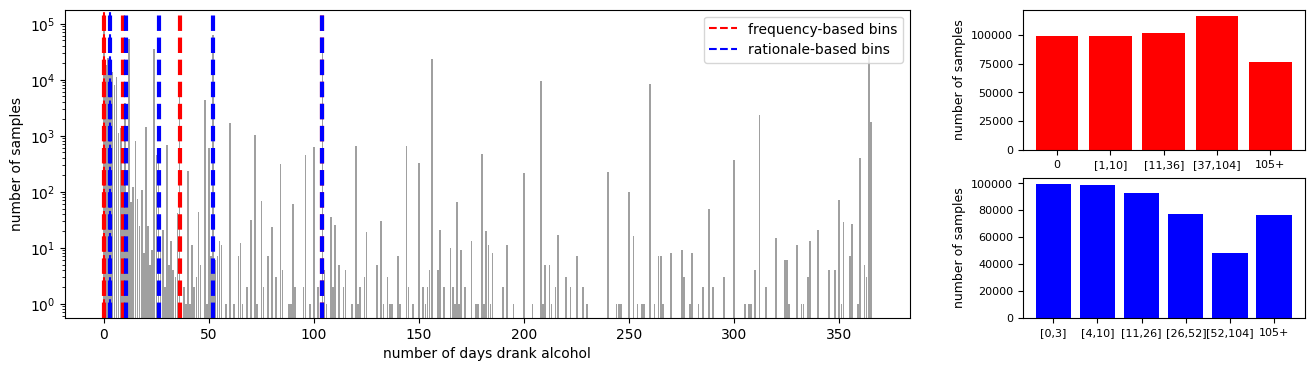

In [10]:
# create figure with gridspec for layout control
fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])  

# --- Left Plot---
ax1 = fig.add_subplot(gs[:, 0])  # Span both rows
ax1.bar(value_counts.index, value_counts.values, color='#A0A0A0')
ax1.set_yscale('log')
ax1.set_ylabel('number of samples', fontsize=10)
ax1.set_xlabel('number of days drank alcohol', fontsize=10)

# Add vertical lines
for x in [0, 9, 36, 104]:
    ax1.axvline(x=x, color='red', linestyle='--', linewidth=3)  # Dashed red lines
for x in [3, 10.5, 26, 52, 104]:
    ax1.axvline(x=x, color='blue', linestyle='--', linewidth=3)
    
# add lines for lables (duplicated from above-needed only for labels)
ax1.axvline(x=0, color='red', linestyle='--', label='frequency-based bins')
plt.axvline(x=3, color='blue', linestyle='--', label='rationale-based bins')

ax1.legend(loc='upper right')

# --- Top Right Plot (Q Grouping) ---
df_alch_q = df_alch.copy()
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 0 if x == 0 else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 1 if 1 <= x <= 10 else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 2 if 11 <= x <= 36 else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 3 if 37 <= x <= 104 else x)
df_alch_q['ALCDAYSYR'] = df_alch_q['ALCDAYSYR'].apply(lambda x: 4 if 105 <= x else x)

value_counts_q = df_alch_q['ALCDAYSYR'].value_counts().sort_index()
ax2 = fig.add_subplot(gs[0, 1])
labels_q = ['0', '[1,10]', '[11,36]', '[37,104]', '105+']
ax2.set_xticks(value_counts_q.index) 
ax2.set_xticklabels(labels_q, fontsize=8, rotation=0)  
ax2.tick_params(axis='y', labelsize=8)
ax2.bar(value_counts_q.index, value_counts_q.values, color='red')
ax2.set_ylabel('number of samples', fontsize=9)


# --- Bottom Right Plot (KN Grouping) ---
df_alch_kn = df_alch.copy()
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 0 if x == 0 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 1 if 1 <= x <= 10 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 2 if 11 <= x <= 26 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 3 if 26 <= x <= 52 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 4 if 53 <= x <= 104 else x)
df_alch_kn['ALCDAYSYR'] = df_alch_kn['ALCDAYSYR'].apply(lambda x: 5 if 105 <= x else x)

value_counts_kn = df_alch_kn['ALCDAYSYR'].value_counts().sort_index()
ax3 = fig.add_subplot(gs[1, 1])
labels_kn = ['[0,3]', '[4,10]', '[11,26]', '[26,52]', '[52,104]', '105+']
ax3.set_xticks(value_counts_kn.index)  # Set positions of ticks
ax3.set_xticklabels(labels_kn, fontsize=8, rotation=0)  # Replace tick labels
ax3.tick_params(axis='y', labelsize=8)
ax3.bar(value_counts_kn.index, value_counts_kn.values, color='blue')
ax3.set_ylabel('number of samples', fontsize=9)


plt.savefig('alch_distribution_plots.png', format='png', dpi=300)
plt.show()